We have previously discussed using shapes for step/jump/transition detection: <a href="https://bayes-shape-calc.github.io/examples/steps/jumps/2021/11/21/Step-Detection.html">Step detection</a>


This notebook, however, will serve as an addendum to that discussion, with more insight into Bayesian Inference-based Template Search (BITS) vs. general shape processing.  We will be trying to find 2 transitions in datasets of variable length and will use both BITS and general shape comparison.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import scipy.special
import statistics as st
from math import lgamma
import numba as nb
from numba import jit

Let's start by generating some fake data.  We will use the same setup as the previous notebook, and provide a sample dataset below.

In [2]:
#generate data
@nb.njit
def data_generator(num_points, num_jumps, jump_size, noise_size, drift_size, blur, seed):
    
    np.random.seed(444 + seed)

    # parameters of fake data
    nt = num_points
    nj = num_jumps
    
    # generating noise & drift
    tjumps = []
    while len(tjumps) < nj:
        time = int(np.random.exponential(scale=nt/2))
        if time < nt-50 and time > 50:
            if len(tjumps) > 0:
                if np.min(np.abs(np.array(tjumps) - time)) > jump_size + blur:
                    tjumps.append(time)
            else:
                tjumps.append(time)
    tjumps.sort()
    
    zsteps = np.zeros(nj)
    for i in range(nj):
        zsteps[i] = jump_size
    noise = np.ones(nt)
    drift_arr = np.ones(nt)
    for i in range(nt):
        noise[i] = np.random.normal()*noise_size
        drift_arr[i] = np.random.normal()*drift_size
    drift = drift_arr.cumsum()
    
    # generating "true" path
    z = np.zeros(nt)
    
    for i in range(nj):
        z[tjumps[i]:] += zsteps[i]
        
    data = z + drift + noise
    
    # calculating snr
    snr = []
    for i in range(len(zsteps)):
        if i == 0:
            snr.append(zsteps[i]/np.std((noise+drift)[:tjumps[i+1]]))
        elif i == len(zsteps)-1:
            snr.append(zsteps[-1]/np.std((noise+drift)[tjumps[-2]:]))
        else:
            snr.append((zsteps[i]/np.std((noise+drift)[tjumps[i]:tjumps[i+1]])))
    '''
    #print('SNR = ' + str(st.mean(snr)))
    #plotting
    fig,ax = plt.subplots(1,1,figsize=(12,4))
    ax.plot(data,'k',lw=.5);
    #ax[1].plot(data,'o',color='k',markersize=1)
    #ax[1].plot(z+drift,lw=2,color='r')
    #for aa in ax:
    #    for i in range(nj):
    #        aa.axvline(x=tjumps[i],color='r',lw=1,zorder=-1,alpha=.5)
    for i in range(nj):
        ax.axvline(x=tjumps[i],color='r',lw=1,zorder=-1,alpha=.5)
    ax.set_title('Actual Transitions')
    #ax[1].set_title('Simulated Path')
    plt.show()
    '''  
    return data, tjumps, np.mean(np.array(snr))

SNR = 3.559


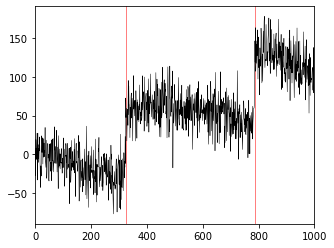

In [3]:
data, tjumps, snr = data_generator(num_points=1000, num_jumps=2, jump_size=80, noise_size=20,
                                          drift_size=1, blur = 0, seed = 45)
print('SNR = %.3f'%snr)

#plotting
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(data,'k',lw=.5);
for i in range(len(tjumps)):
    ax.axvline(x=tjumps[i],color='r',lw=1,zorder=-1,alpha=.5)
#ax.set_title('Actual Transitions')
plt.xlim(0,1000)
plt.savefig('/home/anjali/Documents/BITS_figures/Representative_trace_2.pdf')
plt.show()

We now create an evidence function corresponding to equation 2.2.1 in the SI of the Bayesian shape calculation paper. This function takes in data, a template, and a variable prior for m (scaling nuisance parameter) and returns the evidence that the input data has the same shape as the template.

In [4]:
@nb.jit(nb.float64(nb.float64[:],nb.float64,nb.float64[:]),nopython=True)
def evidence_template(data, prior_m, template): # corresponds to Eq. 2.2.1 in SI for shape calculations
    
    # constant evidence statistics
    N = float(data.size)
    m = (N-2.)/2.

    ey = np.mean(data)
    eyy = np.mean(data*data)
    vy = eyy - ey*ey + 1e-300 ## helps with over/underflow
    
    # priors for m (scale), b (offset), tau (noise)   
    log_l = 0
    log_del_m = np.log(prior_m) 
    log_del_b = np.log(1e5)
    log_del_tau = np.log(1e5)
    log_l -= (log_del_m + log_del_b + log_del_tau)
        
    # template-dependent evidence statistics
    ex = np.mean(template)
    exx = np.mean(template*template)
    exy = np.mean(template*data)
    vx = exx - ex*ex + 1e-300 ## helps with over/underflow
    vxy = exy - ex*ey + 1e-300 ## helps with over/underflow
    r= vxy/np.sqrt(vx*vy)
    r2 = r*r
    
    # evidence integral
    log_l += -m*np.log(np.pi)
    log_l += -N/2*np.log(N)
    log_l += lgamma(m) 
    log_l += -0.5*np.log(vx)
    log_l += -m*np.log(vy)
    log_l += -m*np.log(1.-r2) 
    log_l += -np.log(2)
    #log_l += np.log(1.+(r/np.abs(r))*sc.special.betainc(0.5,m,r2))   

    return log_l

We also create an evidence function corresponding to equation 2.2.4 in the SI of the Bayesian shape calculation paper. This function takes in data and returns the evidence that the input data can be described by a "flat" template.  Conceptually, this "flat" template can be thought of as a null case and alternative hypothesis; it represents the absence of shape, or latent structure, in the data. 

In the Bayesian shape calculation paper, we describe the importance of this null template as it allows us to move beyond "Which template in out set is optimal?" and instead ask the question: "Does the data look more like any of our templates than like uncorrelated noise?" By having this alternative hypothesis, we are not forced to overfit and choose the "best" answer from our set of templates. Instead, if no particular template has an evidence which dominates over the null template, we conclude that the data does not look like any of our templates.

In [5]:
@nb.jit(nb.float64(nb.float64[:]),nopython=True)
def evidence_flat(data): # corresponds to Eq. 2.2.4 in SI for shape calculations
    
    N = float(data.size)
    m = (N-2.)/2.

    ey = np.mean(data)
    eyy = np.mean(data*data)
    vy = eyy - ey*ey + 1e-300 ## helps with over/underflow

    # evidence integral
    log_l = -(m + .5)*np.log(np.pi)
    log_l += -(N/2)*np.log(N)
    log_l += lgamma(m +.5) 
    log_l += -(m + 0.5)*np.log(vy)
    log_del_b = np.log(1e5)
    log_del_tau = np.log(1e5)
    log_l -= (log_del_b + log_del_tau)
    
    return log_l

In the previous notebook, the goal was to find two arbitrarily located signal jumps in a dataset of 600 data points.  To do so, an exhaustive set of 360,000 templates was created, wherein each template was the full length of the dataset, with all possible combinations of the 2 jump locations represented. This sort of general shape analysis is admittedly not very scalable.  Even for this small example of 2 jumps, the set of templates required grows as $\mathcal{O}(N^2)$ where $N$ is the number of points in the dataset.  

More generally, the set of templates required scales both with the number of data points, $N$ and the number of features to find, $R$, as $\mathcal{O}(N^{R})$.  The number of computations required, however, grows as $\mathcal{O}(N^{R+1})$.  We pick up an extra +1 in the exponent from generating and comparing all $N^R$ templates to $N$ data points. 

Below we have the code for generating our set of full data templates and calculating their associated evidences.  The bayes factor of the template evidences is compared to the bayes factor for the null evidence in a process known as Bayesian Model Selection (BMS). Once the templates which maximize this comparison are identified, we use them to return as the most probable locations for transitions.

In [6]:
@nb.jit(nb.float64[:,:](nb.float64[:],nb.float64),nopython=True)
def full_shape_ev(data, prior_m):
    nt = len(data)
    m = prior_m
    lnevs = np.zeros((nt,nt)) + np.nan
    temp = np.zeros_like(data)
    
    for i in range(nt): ## sweep jump 1
        for j in range(nt): ## sweep jump 2
            ## make the template
            temp *= 0
            temp[i:] = 1
            temp[j:] = 2
            
            ## calculate evidence          
            lnevs[i,j] = evidence_template(data, m, temp)
            
    return lnevs

In [7]:
@nb.jit(nb.int64[:](nb.float64[:],nb.float64),nopython=True)
def full_shape(data, prior_m):
    
    ## calculate evidence          
    ln_evs = full_shape_ev(data, 10**8)
    if (np.isfinite(ln_evs)).any() == False:
        print('NaN Alert')
        return np.array([0])
    else:
        _l = ln_evs.flatten()
        _l -= np.max(_l)
    
    ln_prior = -np.log(_l.size) ## equal 1/N priors
    joint = np.exp(_l+ln_prior)
    
    ## use BMS to find transitions
    bms_probs = joint/joint.sum()
    bms_array = np.empty_like(ln_evs)
    for i in range(0, _l.size, ln_evs.shape[0]):
        ind = int((i+ln_evs.shape[0]) / ln_evs.shape[0] - 1)
        bms_array[ind,:] = bms_probs[i:i+ln_evs.shape[0]]
        
    transitions = []
    for i in np.nonzero(bms_array == bms_array.max()):
        transitions.append(i[0])
    
    return np.array(transitions)

Here, instead of creating thousands of templates that span the entire dataset, we exploit the localized nature the features we are looking for.  We can generate a template that is just large enough to capture the behavior we are searching for, and then scan it across our dataset.  We perform the usual BMS calculation on a slice of our data corresponding to the template location, before translating over one datapoint and repeating the process.  In effect, this is equivalent to executing a linear search of our localized template through the full dataset (with the caveat that points on the edge will be missed).

This approach greatly allievates the scaling headache faced by the more general shape calculation approach described above.  Here, we only need one template regardless of $N$, the size of our dataset.  Additionally, in this example, there are two transitions which have the same shape.  Since we can move our template, we don't have to treat them like distinct features and we can still use just one template, regardless of the number of transitions we have.  The number of calculations required for BITS grows as $\mathcal{O}(CN)$ where $C$ is the number of $\textbf{distinct}$ features we are searching for.

In [8]:
@nb.jit(nb.int64[:](nb.float64[:],nb.float64,nb.int64,nb.int64),nopython=True)
def BITS(data, prior_m, tail_size, blur_size=0):
    
    # jump template
    """
    tmp_jump = np.ones(tmp_size,dtype=nb.float64)
    for i in range(tmp_size):
        if i >= tmp_size / 2.:
            tmp_jump[i] = 1.
        else:
            tmp_jump[i] = 0.
    """
            
    # blurred template
    tt = tail_size // 2
    temp = np.zeros(blur_size + 2 * tt,dtype=nb.float64) 
    tmp_size = blur_size + 2 * tt
    ind = np.arange(tt, tt+blur_size, 1)
    temp[ind] = np.linspace(0., 1., len(ind))
    temp[-tt:] = 1
    
    # calculate evidences
    ev_jump = np.empty(data.shape[0] - tmp_size)
    ev_flat = np.empty(data.shape[0] - tmp_size)
    
    for i in range(0, data.shape[0] - tmp_size):
        sub = data[i:i+tmp_size]
        #print(type(sub[0]))
        ev_jump[i] = evidence_template(sub, prior_m, temp)
        ev_flat[i] = evidence_flat(sub)
    
    # use BMS to calculate posteriors
    #ev_line = np.ones_like(ev_step) * -np.inf
    bayes_jump = ev_flat - ev_jump
    bayes_flat = ev_jump - ev_flat
    
    prob_jump = 1. / (1. + np.exp(bayes_jump))
    prob_flat = 1. / (1. + np.exp(bayes_flat)) 
    
    # taking out repeats
    jump = np.where(prob_jump>=0.85)[0]
    
    if len(jump) == 0:
        return jump
    elif len(jump) == 1:
         transitions_jump = jump
    else:
        if np.min(np.diff(jump))<=tmp_size:
            jump_split = np.split(jump, np.argwhere(np.diff(jump)>=tmp_size).flatten()+1)
            ind = 0
            transitions_jump = np.ones(len(jump_split),dtype=nb.int64)
            for i in jump_split:
                transitions_jump[ind] = i[np.argmax(prob_jump[i])]
                ind += 1 
      
    return transitions_jump + round(tmp_size / 2)

Let's take a look at how both of these methods scale.

In [9]:
import datetime

BITS_times = []
full_times = []

dp = [300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000]
for i in dp:
    print('%d Datapoints complete'%(i))

    ## generate data
    data, tjumps, snr = data_generator(num_points=i, num_jumps=2, jump_size=80, noise_size=20,
                                          drift_size=1, blur = 0, seed = 76)

    timers_bits = np.zeros(10)
    timers_full = np.zeros(10)
    for i in range(10):
        #print('iteration %d'%(i))
        ## time BITS
        start = datetime.datetime.now()
        tran_BITS = BITS(data, 10**8, 55, blur_size=0)
        finish = datetime.datetime.now()
        if (tjumps == tran_BITS).all():
            timers_bits[i] = (finish-start).total_seconds()
        else:
            print('failed to find all transitions - BITS')
        
        ## time full shape analysis
        start = datetime.datetime.now()
        tran_full = full_shape(data, 10**8)
        finish = datetime.datetime.now()
        if (tjumps == tran_full).all():
            timers_full[i] = (finish-start).total_seconds()
        else:
            print('failed to find all transitions - full')
        
    full_times.append(np.median(timers_full))
    BITS_times.append(np.median(timers_bits))

300 Datapoints complete
600 Datapoints complete
900 Datapoints complete
1200 Datapoints complete
1500 Datapoints complete
1800 Datapoints complete
2100 Datapoints complete
2400 Datapoints complete
2700 Datapoints complete
3000 Datapoints complete


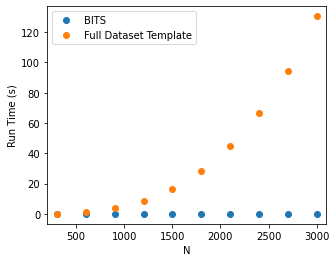

In [10]:
plt.figure(figsize=(5,4))
plt.plot(dp, BITS_times, 'o', label='BITS')
plt.plot(dp, full_times, 'o', label='Full Dataset Template')
plt.legend(loc=0)
#plt.title('Linear Axes')
plt.xlabel('N')
plt.xlim(200,3100)
plt.ylabel('Run Time (s)')
plt.savefig('/home/anjali/Documents/BITS_figures/2Features_linear.pdf')
plt.show()

We note some exponential behavior for the full dataset template curve, while the BITS times grow linearly.  Let's investigate further with a loglog plot.

BITS fit: y = 1.009*m + -14.301
Full Dataset Template fit: y = 2.908*m + -18.446


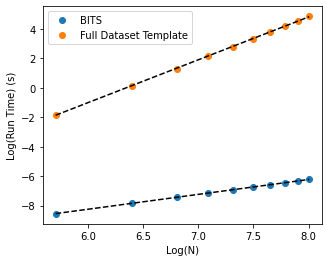

In [11]:
from scipy.optimize import curve_fit

## log plotting
plt.figure(figsize=(5,4))
plt.plot(np.log(dp), np.log(BITS_times), 'o', label='BITS')
plt.plot(np.log(dp), np.log(full_times), 'o', label='Full Dataset Template')
plt.legend(loc=0)

## curve-fitting
def linear(x, m, b):
    return m*x + b

popt, pcov = scipy.optimize.curve_fit(linear, np.log(dp), np.log(BITS_times))
plt.plot(np.log(dp), linear(np.log(dp), popt[0], popt[1]), 'k--')
print('BITS fit: y = %.3f*m + %.3f'%(np.round(popt[0],3), np.round(popt[1],3)))

popt, pcov = scipy.optimize.curve_fit(linear, np.log(dp), np.log(full_times))
plt.plot(np.log(dp), linear(np.log(dp), popt[0], popt[1]), 'k--')
print('Full Dataset Template fit: y = %.3f*m + %.3f'%(np.round(popt[0],3), np.round(popt[1],3)))

## finishing up plot
#plt.title('Log-Log Plot');
plt.xlabel('Log(N)')
plt.ylabel('Log(Run Time) (s)')
plt.savefig('/home/anjali/Documents/BITS_figures/2Features_loglog.pdf')

After fitting, we see that our Big-$\mathcal{O}$ predictions are empirically confirmed.  The BITS slope is $\approx 1$ which matches $\mathcal{O}(CN) = \mathcal{O}(N)$, while the full dataset slope is $\approx 3$ which matches $\mathcal{O}(N^{R+1}) = \mathcal{O}(N^{3})$. 